<a href="https://colab.research.google.com/github/danielyangdev/CAIS-F23-Curriculum/blob/main/%5BL5%5D_Intro_to_Computer_Vision_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        
**VERY IMPORTANT:**
Use Google's free GPU to train your models much faster!

From the top left menu bar, navigate: `Runtime --> Change runtime type --> Hardware accelerator Dropdown Menu --> Select "GPU"`

# **Lesson 5 Notebook: CNNs**
**Notebook Objective:**
In this notebook, you'll experiment with defining your own Convolutional Neural Network, using the [Cifar-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a popular benchmark dataset consisting of 10 classes, with some pretty small images (32 x 32 pixels).

**Useful Links:**
- [Intro to CNNs](https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac): as a recap, a great article covering how CNNs work

**CNN Overview:**
- **Input image** --> successive stacking of **Convolution** and **Pooling** layers --> **Flatten** --> **FC layers** for classification!
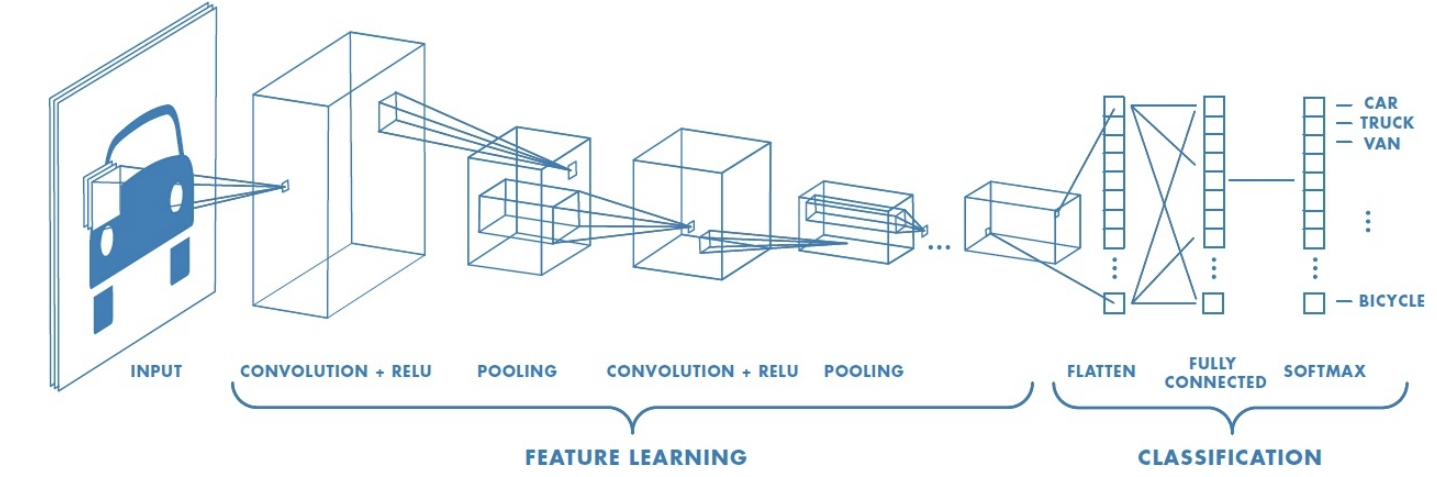

## **Loading Data**
Here, we will load the CIFAR-10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Giving Colab access to the Drive
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Other/CAIS++/F23_Curriculum/Colab_Notebooks

Mounted at /content/drive/
/content/drive/My Drive/Other/CAIS++/F23_Curriculum/Colab_Notebooks


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# define batch_size
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 28951629.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Next, let's visualize some images, as well as their respective labels.

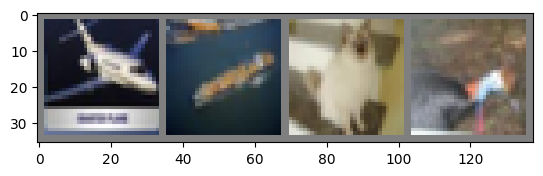

plane ship  cat   bird 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## **Defining the CNN**
Here we will define the Convolutional Neural Network, which consists of convolutions, pooling, and linear layers. We also want you to utilize **Batch Normalization**, an import concept that made the family of ResNet so successful.

Here is an in-depth article on [Batch-Normalization](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/), but for a TLDR, **batch norm** is a process of **normalizing and standardizing outputs of one layer before passing it on to the next layer**. In practical coding, we add it *after* the activation function of the output layer or *before* the activation function of the input layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

############### YOUR CODE STARTS HERE ####################
# Define the CNN; for an extra challenge, play around with the number & types of layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # define your first convolution with a kernel size
        # Hint: how many channels does your input image have? How many pixels?
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        # define batch norm 1
        self.bn1 = nn.BatchNorm2d(32)
        # define your second convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # define batch norm 2
        self.bn2 = nn.BatchNorm2d(64)
        # define your third convolution
        self.conv3 = nn.Conv2d(32, 128, kernel_size=3)
        # define batch norm 3
        self.bn3 = nn.BatchNorm2d(128)
        # define pooling
        self.pool = nn.MaxPool2d(2, 2)
        # define your FC layer(s)... the last FC layer has output of size...?
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        # successive convolutions, BN, and pooling
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

################# YOUR CODE ENDS HERE #################
net = Net()

## **Compiling the Network**
We will define our loss and optimizer here.

In [10]:
import torch.optim as optim

# define loss for multi-class classification
criterion = nn.CrossEntropyLoss()
# define your optimizer
optimizer = optim.NAdam(net.parameters(), lr=0.001)

## **Training the CNN**
Now let's train the CNN model we just created!

In [11]:
num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 250 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 250:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

##**Evaluating the CNN**
We will now get the ground truth for a few images, see what our model predicts, and compare the two.

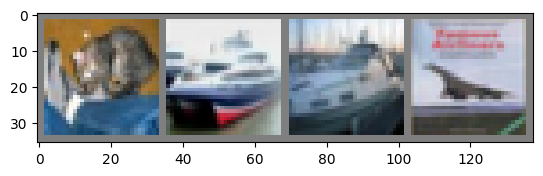

GroundTruth:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_display = images[:4]

# print images
imshow(torchvision.utils.make_grid(images_display))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
outputs = net(images)

RuntimeError: ignored

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

NameError: ignored

Let's test our model on more images to get a better idea of our test accuracy.

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

RuntimeError: ignored

In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

RuntimeError: ignored

## Great work!